# ANA22

## A NB to draft Na-22 analysis

In [1]:
import time

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [7]:
import Core.system_of_units as units
import tables
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [8]:
from Database import loadDB

In [9]:
import ICython.Sierpe.cBLR as cblr

In [10]:
#%matplotlib notebook

In [11]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

04/12/2016
16:26:32


### Access to LSC

### Script DAQ to h5

### Plotting functions

In [12]:
def SetPlotLabels(xlabel="", ylabel="", grid=True):
    """
    Short cut to set labels in plots
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if grid is True:
        plt.grid(which="both", axis="both")


In [13]:
def plot_signal(signal_t, signal, title="signal",
                signal_start=0, signal_end=1e+4, ymax = 200, units=""):
    """
    Given a series signal (t, signal), plot the signal
    """

    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([0, ymax])
    SetPlotLabels(xlabel="t (ns)", ylabel="signal (%s)" % units)
    plt.title(title)
    plt.plot(signal_t, signal)
    plt.show()

### Deconvolution functions

In [14]:
def deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=0):
    """
    Deconvolution of all the PMTs in the event cython function
    """
    NPMT = pmtrwf.shape[1]
    CWF = []
    
    for pmt in range(NPMT):
       
        signal_r, acum, baseline, baseline_end, noise_rms = cblr.deconvolve_signal_acum(pmtrwf[event,pmt],
                                                                                  n_baseline=n_baseline,
                                                                                  coef_clean=DataPMT.coeff_c[pmt],
                                                                                  coef_blr=DataPMT.coeff_blr[pmt],
                                                                                  thr_trigger=thr_trigger,
                                                                                  acum_discharge_length = 5000)
        CWF.append(signal_r)
            
        
    return np.array(CWF)

### Peak finding, rebinning and ZS functions

In [15]:
def pmt_sum(CWF,DataPMT):
    """
    input: sensor (pmt or sipm) data vector, sensor data frame (position, calibration)
    returns: a panel holding waveforms for all sensors, and a series for the baselines
    """
    
    NPMT = len(CWF)
    NWF = len(CWF[0])
    adc_to_pes = abs(DataPMT.adc_to_pes.values)
    csum = np.zeros(NWF, dtype=np.double)
    for j in range(NPMT):
        csum += CWF[j]*1./adc_to_pes[j]
    return csum



In [16]:
def wfdf(time,energy_pes):
    """
    takes three vectors (time, energy and indx) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_mus'] = time/units.mus
    swf['ene_pes'] = energy_pes 
    return pd.DataFrame(swf)

In [17]:
def wf_thr(wf,threshold=0):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

In [18]:
def find_peaks(wfzs, stride=4, lmin=8):
    """
    Find peaks. 
    do not interrupt the peak if next sample comes within stride
    accept the peak only if larger than lmin samples
    """
    T = wfzs['time_mus'].values
    P = wfzs['ene_pes'].values
    I = wfzs.index.values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(wfzs)) :
        if wfzs.index[i]-stride > wfzs.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        if len(S12[i]) > lmin:
            S12L.append(pd.DataFrame(S12[i], columns=['time_mus','ene_pes','index']))
    return S12L

In [118]:
def pmt_peaks(pmtrwf, DataPMT, event=0, threshold=2, stride=4, lmin=8, n_baseline=28000, thr_trigger=5):
    CWF  = deconv_pmt(pmtrwf, DataPMT, n_baseline=n_baseline, thr_trigger=thr_trigger, event=event)
    pmtsum = pmt_sum(CWF,DataPMT)
    swf = wfdf(signal_t,pmtsum)
    wfzs = wf_thr(swf,threshold=2)
    S12 = find_peaks(wfzs, stride=stride, lmin=lmin)
    return CWF, pmtsum, swf, wfzs, S12
    

In [165]:
def scan_S12(S12):
    print('number of peaks = {}'.format(len(S12)))
    for i,s in enumerate(S12):
        print('S12 number = {}, samples = {} sum in pes ={}'.format(i, len(s), np.sum(s.ene_pes.values)))
        plt.plot(s.time_mus.values,s.ene_pes)
        plt.show()
        raw_input('hit return')

### Run 3054

#### Run conditions: 
1. Trigger on S1 at ~80 pes (should select 1.275 MeV gamma)

In [19]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run3054

run_3054.gdc1next.000.next1el_3054.root.h5


In [20]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run3054/'

In [21]:
ffile = 'run_3054.gdc1next.000.next1el_3054.root.h5'

In [22]:
r3054 = tables.open_file(path+ffile,'r+')

In [23]:
pmtrwf = r3054.root.RD.pmtrwf

### Detailed analysis of first event

#### Raw waveform

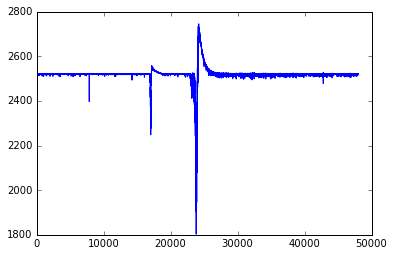

In [24]:
plt.plot(pmtrwf[0,0])


#### Features
1. S1 clearly visible
2. One S2 (X-ray) before Na-22 electron
3. Electron shower after S2 
4. Some electron showers also showing up from previous waveform

In [25]:
DataPMT = loadDB.DataPMT(3054)

In [202]:
adc_to_pes = abs(DataPMT.adc_to_pes.values)

In [203]:
adc_to_pes

array([ 24.3395,  24.858 ,  26.2934,  26.411 ,  26.7098,  22.4456,
        23.3552,  33.8821,  21.822 ,  25.802 ,  19.559 ,  22.197 ])

### Deconvolution

In [26]:
signal_r, acum, baseline, baseline_end, noise_rms = cblr.\
    deconvolve_signal_acum(pmtrwf[0,0],
                           n_baseline=500,
                           coef_clean=DataPMT.coeff_c[0],
                           coef_blr=DataPMT.coeff_blr[0],
                           thr_trigger=5,
                           acum_discharge_length = 5000)

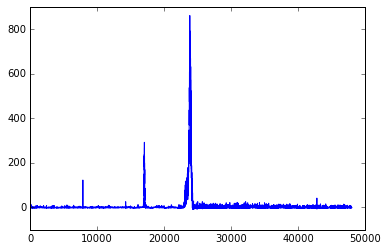

In [27]:
plt.plot(signal_r)

In [28]:
tw = len(signal_r)*25

In [29]:
step = 25

In [30]:
len(signal_r)

48000

In [31]:
signal_t = np.arange(0., tw, step)

In [32]:
len(signal_t)

48000

In [ ]:
signal_t = np.arange(0., tlen(signal_r)*25, 25)

### Waveform features

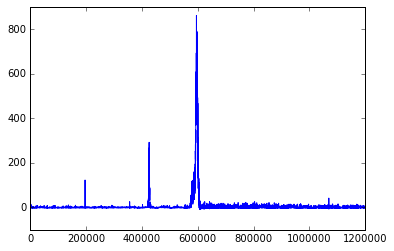

In [33]:
plt.plot(signal_t,signal_r)

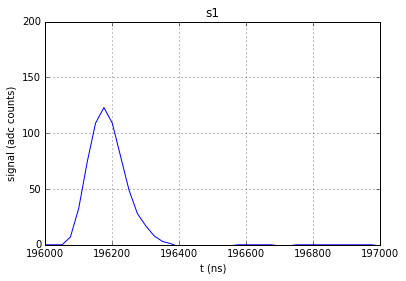

In [34]:
plot_signal(signal_t, signal_r, title="s1",
                signal_start=196e+3, signal_end=197e+3, ymax = 200, units="adc counts")

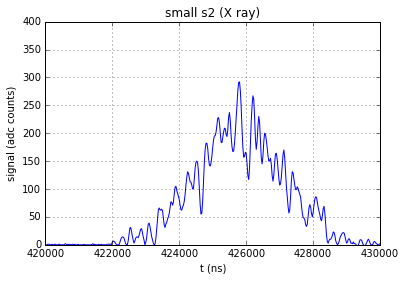

In [35]:
plot_signal(signal_t, signal_r, title="small s2 (X ray)",
                signal_start=420e+3, signal_end=430e+3, ymax = 400, units="adc counts")

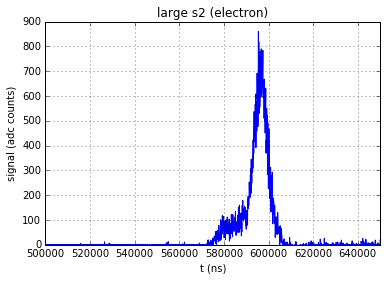

In [36]:
plot_signal(signal_t, signal_r, title="large s2 (electron)",
                signal_start=500e+3, signal_end=650e+3, ymax = 900, units="adc counts")

In [37]:
CWF  = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=0)

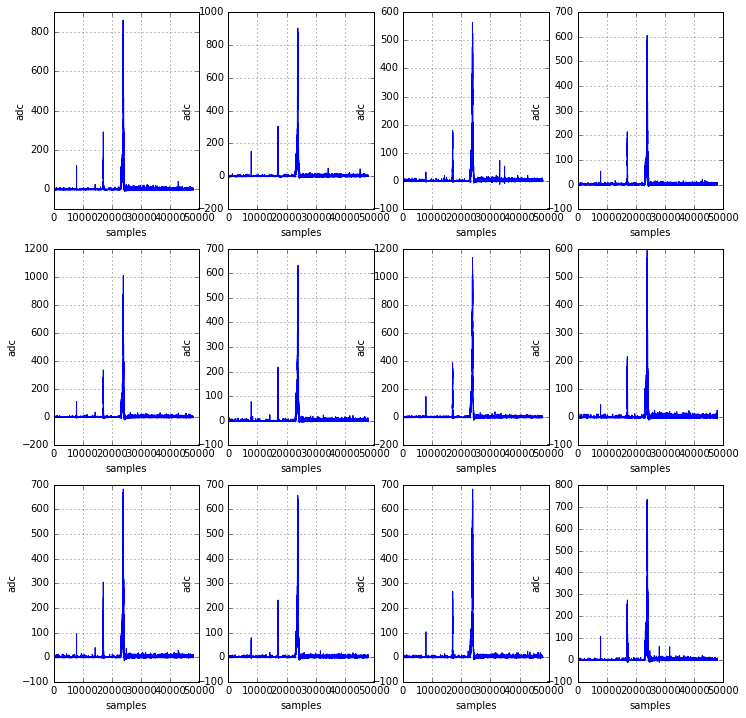

In [38]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=3000)

In [39]:
adc_to_pes = abs(DataPMT.adc_to_pes.values)

In [40]:
adc_to_pes

array([ 24.3395,  24.858 ,  26.2934,  26.411 ,  26.7098,  22.4456,
        23.3552,  33.8821,  21.822 ,  25.802 ,  19.559 ,  22.197 ])

### PMT sum

In [41]:
pmtsum = pmt_sum(CWF,DataPMT)

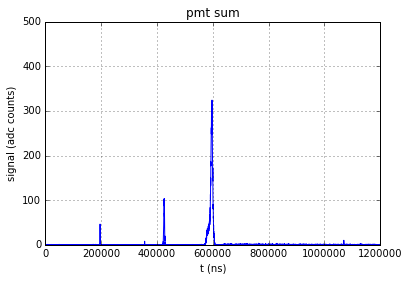

In [42]:
plot_signal(signal_t, pmtsum , title="pmt sum",
                signal_start=0, signal_end=1200e+3, ymax = 500, units="adc counts")

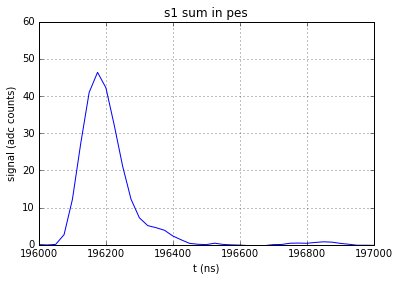

In [43]:
plot_signal(signal_t, pmtsum, title="s1 sum in pes",
                signal_start=196e+3, signal_end=197e+3, ymax = 60, units="adc counts")

#### Sinusoidal noise shows up in S1

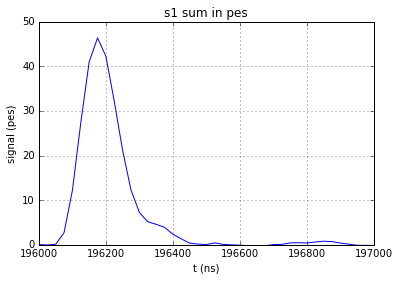

In [44]:
plot_signal(signal_t, pmtsum, title="s1 sum in pes",
                signal_start=196E+3, signal_end=197E+3, ymax = 50, units="pes")

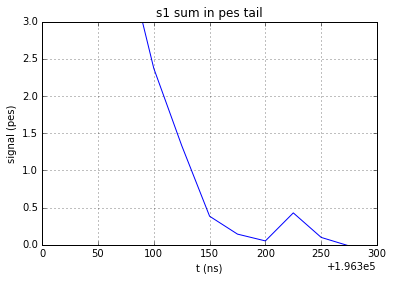

In [45]:
plot_signal(signal_t, pmtsum, title="s1 sum in pes tail",
                signal_start=196300, signal_end=196600, ymax = 3, units="pes")

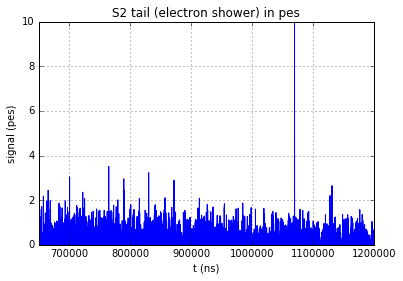

In [46]:
plot_signal(signal_t, pmtsum, title="S2 tail (electron shower) in pes",
                signal_start=650e+3, signal_end=1200e+3, ymax = 10, units="pes")

#### A threshold of 2 pes cuts the bulk of the shower, with 4 cuts all but one

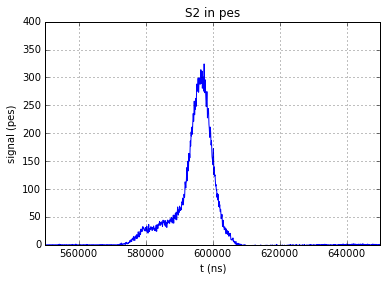

In [47]:
plot_signal(signal_t, pmtsum, title="S2 in pes",
                signal_start=550e+3, signal_end=650e+3, ymax = 400, units="pes")

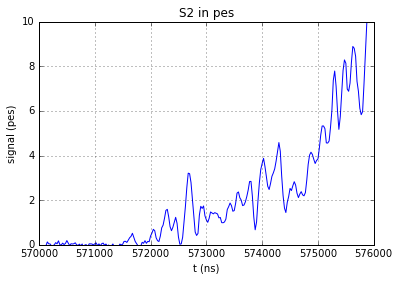

In [48]:
plot_signal(signal_t, pmtsum, title="S2 in pes",
                signal_start=570e+3, signal_end=576e+3, ymax = 10, units="pes")

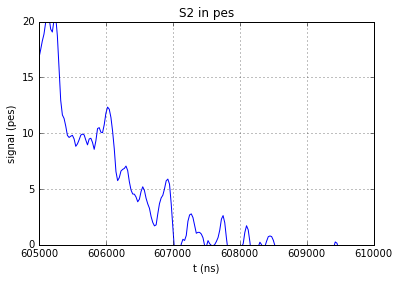

In [49]:
plot_signal(signal_t, pmtsum, title="S2 in pes",
                signal_start=605e+3, signal_end=610e+3, ymax = 20, units="pes")

### Construct a DF with WF

In [50]:
swf = wfdf(signal_t,pmtsum)

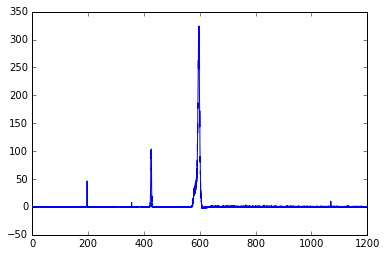

In [51]:
plt.plot(swf.time_mus.values,swf.ene_pes)

### Zero suppression

#### large threshold

In [52]:
wfzs = wf_thr(swf,threshold=4)

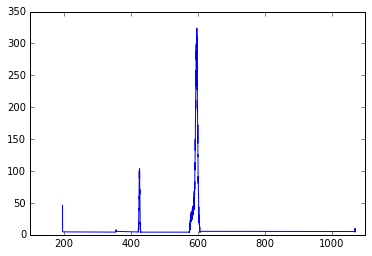

In [53]:
plt.plot(wfzs.time_mus.values,wfzs.ene_pes)

In [54]:
wfzs.time_mus.values[0:20]

array([ 196.1  ,  196.125,  196.15 ,  196.175,  196.2  ,  196.225,
        196.25 ,  196.275,  196.3  ,  196.325,  196.35 ,  355.925,
        355.95 ,  355.975,  356.   ,  356.025,  422.2  ,  422.225,
        422.25 ,  422.325])

In [55]:
wfzs.index.values[0:30]

array([ 7844,  7845,  7846,  7847,  7848,  7849,  7850,  7851,  7852,
        7853,  7854, 14237, 14238, 14239, 14240, 14241, 16888, 16889,
       16890, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900,
       16901, 16902, 16903])

### Find peaks

### Find peaks, large threshold

In [56]:
S12 = find_peaks(wfzs, stride=4, lmin=8)

In [57]:
len(S12)

3

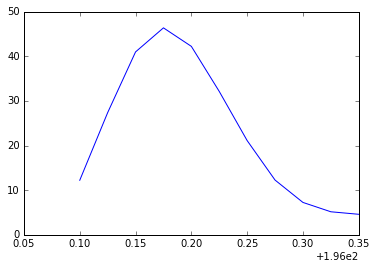

In [58]:
plt.plot(S12[0].time_mus.values,S12[0].ene_pes.values)

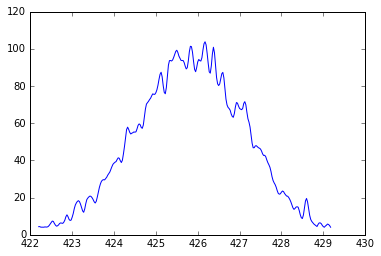

In [59]:
plt.plot(S12[1].time_mus.values,S12[1].ene_pes.values)

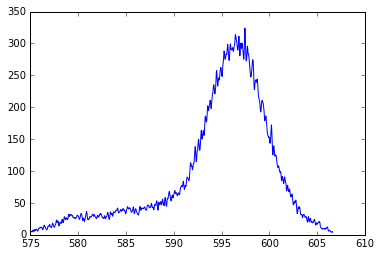

In [60]:
plt.plot(S12[2].time_mus.values,S12[2].ene_pes.values)

In [61]:
len(S12[0])

11

In [62]:
len(S12[1])

278

In [63]:
len(S12[2])

1263

In [64]:
np.sum(S12[0].ene_pes)

251.60181069610172

In [65]:
np.sum(S12[1].ene_pes)

12709.689312149032

In [66]:
np.sum(S12[2].ene_pes)

112883.72145414798

### Find peaks, small threshold

In [67]:
wfzs2 = wf_thr(swf,threshold=2)

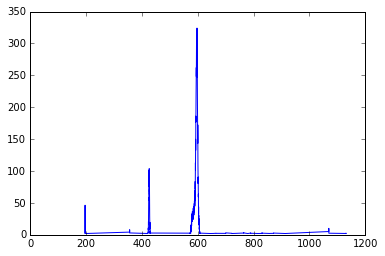

In [68]:
plt.plot(wfzs2.time_mus.values,wfzs2.ene_pes)

In [69]:
S12_2 = find_peaks(wfzs2, stride=4, lmin=8)

In [70]:
len(S12_2)

3

In [71]:
len(S12_2[0])

14

In [72]:
len(S12_2[1])

294

In [73]:
len(S12_2[2])

1316

In [74]:
np.sum(S12_2[0].ene_pes)

260.60564966745397

In [75]:
np.sum(S12_2[1].ene_pes)

12754.944587850398

In [76]:
np.sum(S12_2[2].ene_pes)

113062.58132838317

In [77]:
100.*abs(np.sum(S12_2[2].ene_pes) - np.sum(S12[2].ene_pes))/np.sum(S12_2[2].ene_pes)

0.15819546319723796

#### To conclude first event, it appears that minimum cut of 2 pes, stride of 4 and lmin of 8 are reasonsable values

### Event 2

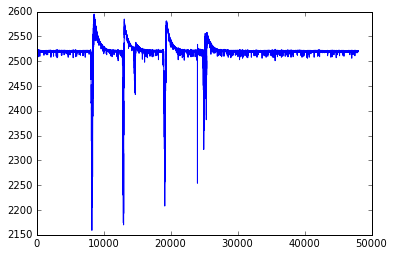

In [78]:
plt.plot(pmtrwf[1,0])

### Many S2! 

In [79]:
CWF  = deconv_pmt(pmtrwf, DataPMT, n_baseline=28000, thr_trigger=5, event=1)

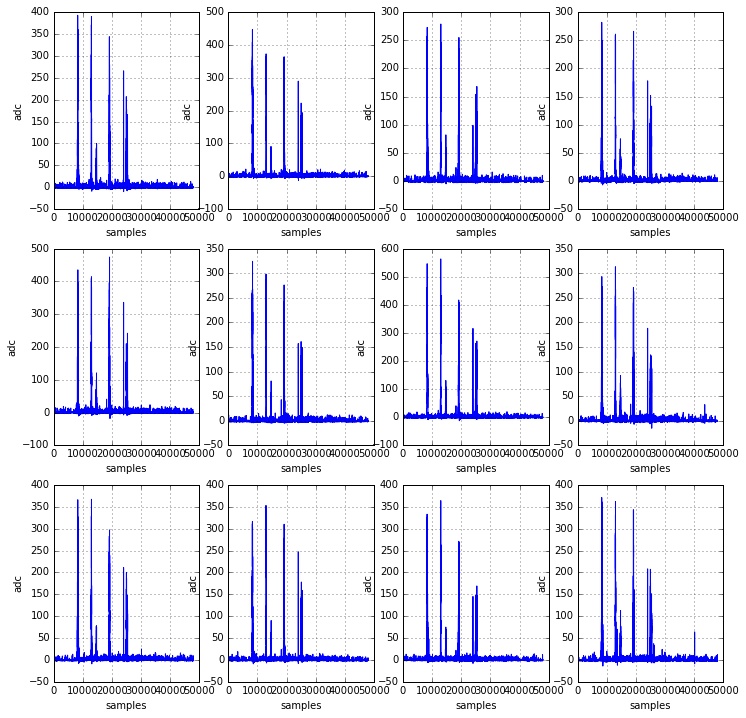

In [80]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=3000)

In [81]:
pmtsum = pmt_sum(CWF,DataPMT)

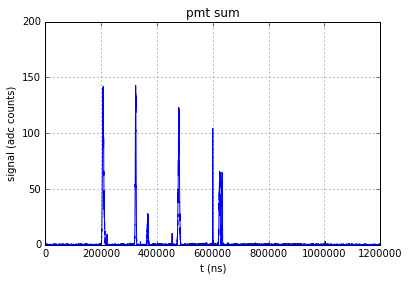

In [82]:
plot_signal(signal_t, pmtsum , title="pmt sum",
                signal_start=0, signal_end=1200e+3, ymax = 200, units="adc counts")

In [83]:
swf = wfdf(signal_t,pmtsum)

In [84]:
wfzs = wf_thr(swf,threshold=2)

In [85]:
S12 = find_peaks(wfzs, stride=4, lmin=8)

In [86]:
len(S12)

10

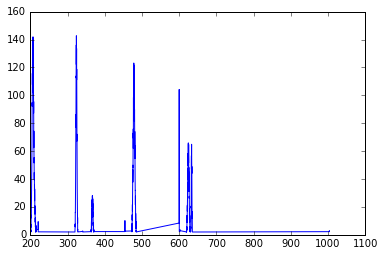

In [87]:
plt.plot(wfzs.time_mus.values,wfzs.ene_pes)

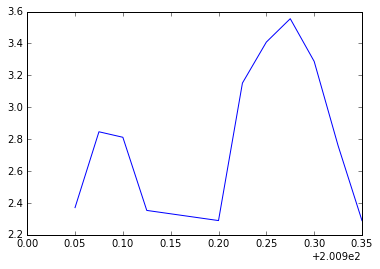

In [88]:
plt.plot(S12[0].time_mus.values,S12[0].ene_pes)

In [89]:
len(S12[0])

11

#### too short! (require minimum 12). Total area and peak to area also small

In [90]:
np.sum(S12[0].ene_pes.values)

31.122590063467566

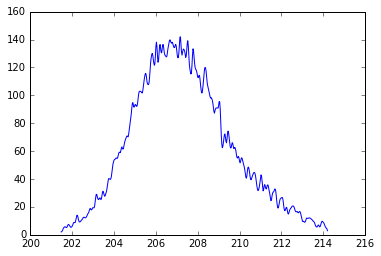

In [91]:
plt.plot(S12[1].time_mus.values,S12[1].ene_pes)

In [92]:
len(S12[1])

510

In [93]:
np.sum(S12[1].ene_pes.values)

30469.218466929182

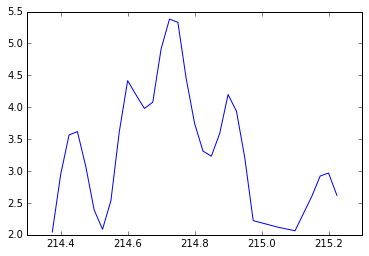

In [94]:
plt.plot(S12[2].time_mus.values,S12[2].ene_pes)

In [95]:
len(S12[2])

31

#### Too long: Require max 20 bins (300 < t < 400 ns). Also, peak to area very small

In [96]:
np.sum(S12[2].ene_pes.values)

105.35549329874209

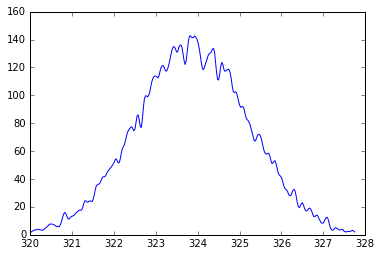

In [97]:
plt.plot(S12[3].time_mus.values,S12[3].ene_pes)

In [98]:
np.sum(S12[3].ene_pes.values)

18319.917567820132

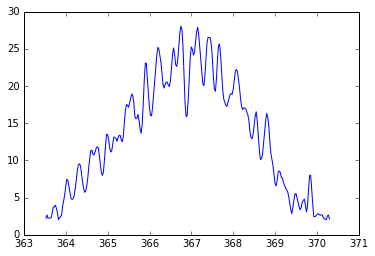

In [99]:
plt.plot(S12[4].time_mus.values,S12[4].ene_pes)

In [100]:
np.sum(S12[4].ene_pes.values)

3638.171661007922

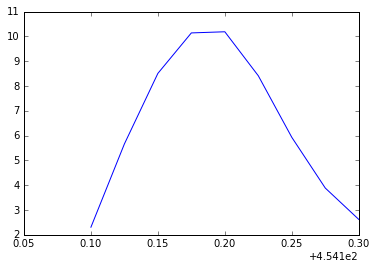

In [101]:
plt.plot(S12[5].time_mus.values,S12[5].ene_pes)

#### This appears to be a genuine S1

In [102]:
len(S12[5])

9

In [103]:
np.sum(S12[5].ene_pes.values)

57.654579657291208

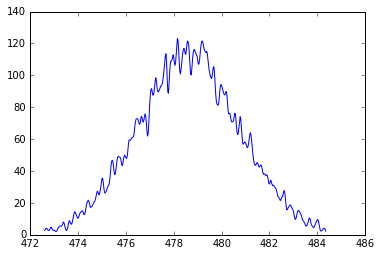

In [104]:
plt.plot(S12[6].time_mus.values,S12[6].ene_pes)

In [105]:
np.sum(S12[6].ene_pes.values)

24130.203618149735

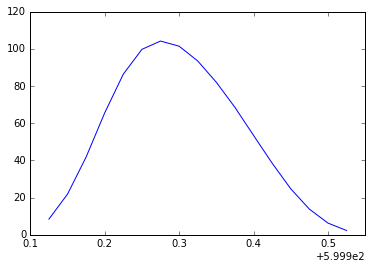

In [106]:
plt.plot(S12[7].time_mus.values,S12[7].ene_pes)

In [107]:
np.sum(S12[7].ene_pes.values)

912.54900000930593

In [108]:
len(S12[7])

17

#### This looks like a bona fide S1 (many pes!)

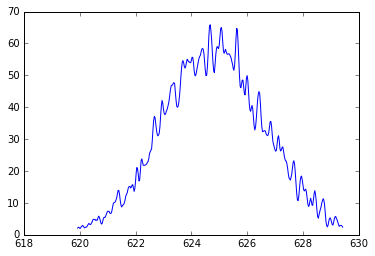

In [109]:
plt.plot(S12[8].time_mus.values,S12[8].ene_pes)

In [110]:
np.sum(S12[8].ene_pes.values)

10771.818178854859

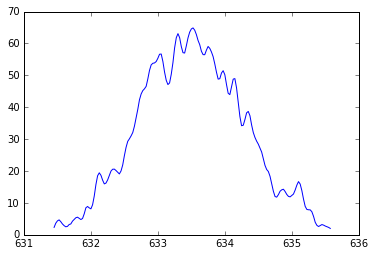

In [111]:
plt.plot(S12[9].time_mus.values,S12[9].ene_pes)

In [112]:
np.sum(S12[9].ene_pes.values)

4874.4414421150559

In [113]:
len(S12)

10

In [114]:
S12[8].time_mus.values[-1]

629.42499999999995

In [115]:
S12[9].time_mus.values[0]

631.45000000000005

In [116]:
np.sum(S12[9].ene_pes.values) + np.sum(S12[8].ene_pes.values)

15646.259620969915

#### Conclusion: Many waveforms, probably many compton scatters, event not useful

### Event 3

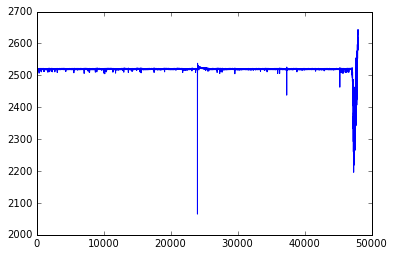

In [117]:
plt.plot(pmtrwf[2,0])

In [119]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=2, threshold=2, stride=4, lmin=8)

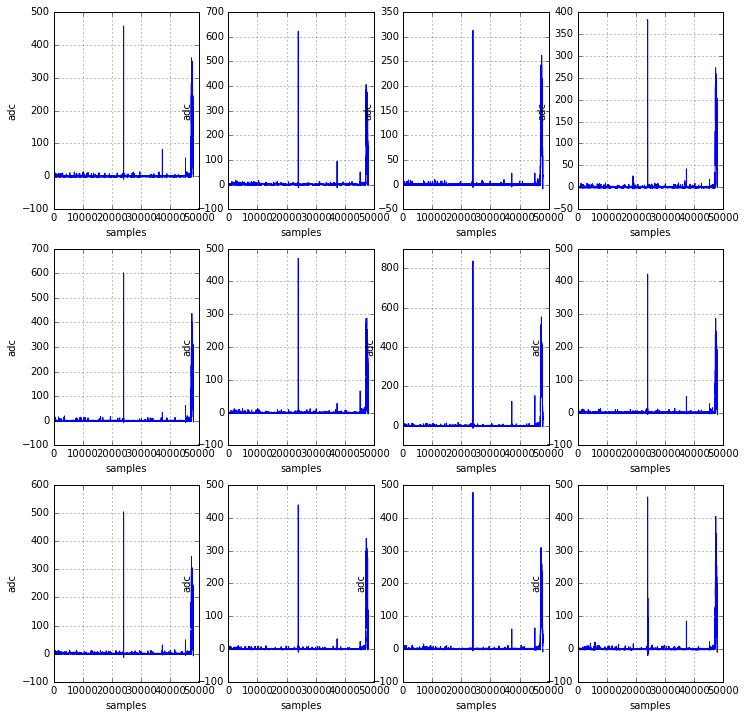

In [120]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=3000)

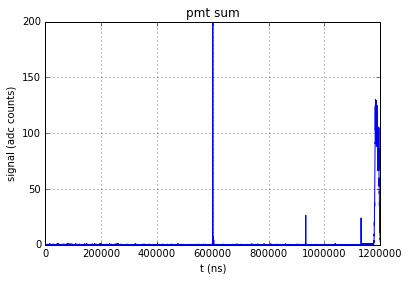

In [121]:
plot_signal(signal_t, pmtsum , title="pmt sum",
                signal_start=0, signal_end=1200e+3, ymax = 200, units="adc counts")

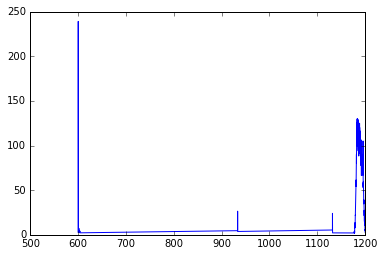

In [122]:
plt.plot(wfzs.time_mus.values,wfzs.ene_pes)

In [123]:
len(S12)

4

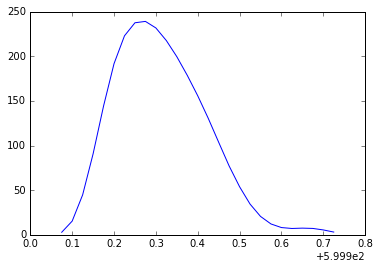

In [124]:
plt.plot(S12[0].time_mus.values,S12[0].ene_pes)

In [125]:
np.sum(S12[0].ene_pes.values)

2642.8916337704813

In [ ]:
len(S12[0])

#### too big to be an S1

### Event 4

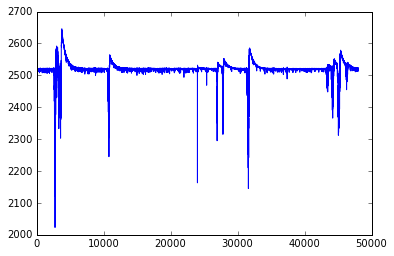

In [126]:
plt.plot(pmtrwf[3,0])

In [127]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=3, threshold=2, stride=4, lmin=8)

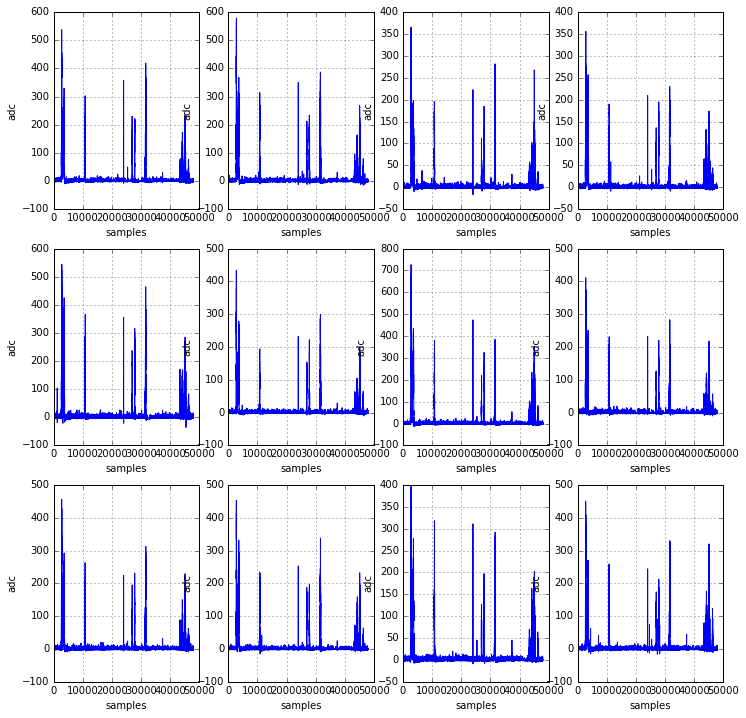

In [128]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=3000)

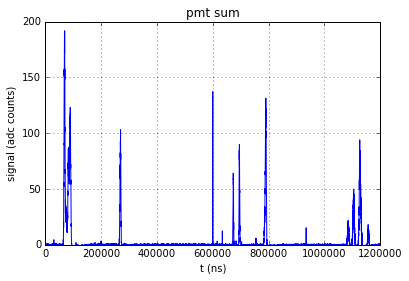

In [129]:
plot_signal(signal_t, pmtsum , title="pmt sum",
                signal_start=0, signal_end=1200e+3, ymax = 200, units="adc counts")

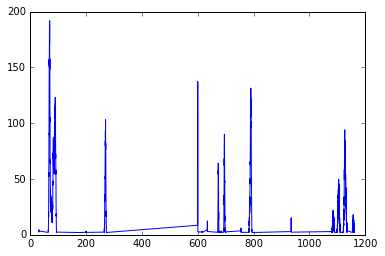

In [130]:
plt.plot(wfzs.time_mus.values,wfzs.ene_pes)

In [131]:
len(S12)

12

S12 number = 0, samples = 1182 sum in pes =72912.0343825


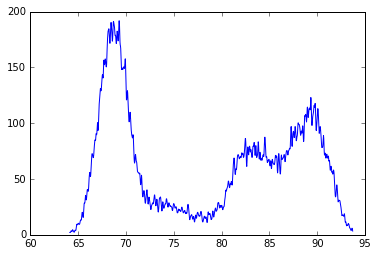

hit return
S12 number = 1, samples = 303 sum in pes =13691.6645683


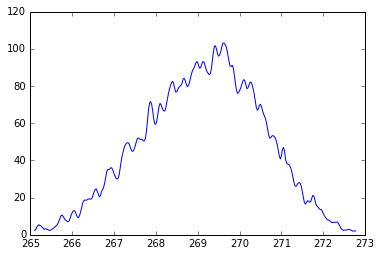

hit return
S12 number = 2, samples = 20 sum in pes =1361.17874206


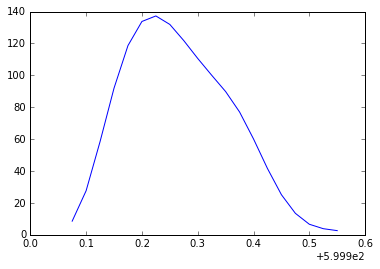

hit return
S12 number = 3, samples = 173 sum in pes =5092.9382093


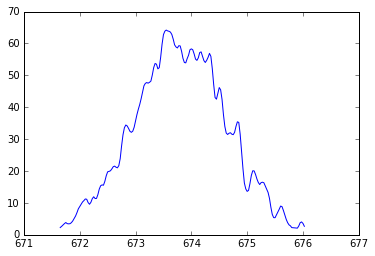

hit return
S12 number = 4, samples = 216 sum in pes =8424.34328864


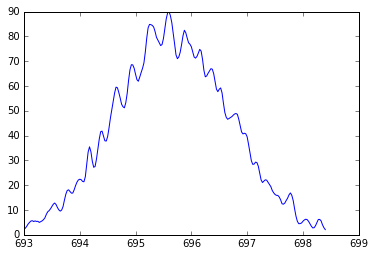

hit return
S12 number = 5, samples = 468 sum in pes =22909.9555258


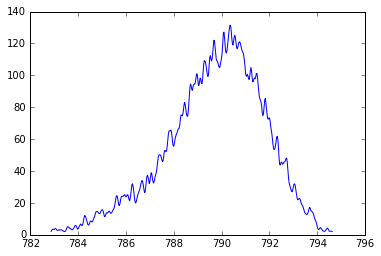

hit return
S12 number = 6, samples = 9 sum in pes =76.6261346561


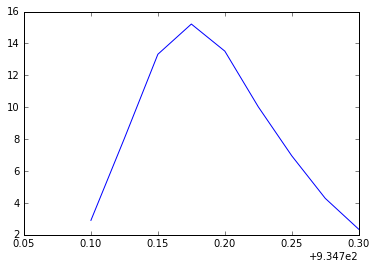

hit return
S12 number = 7, samples = 354 sum in pes =3906.66556193


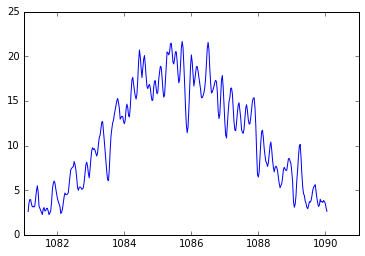

hit return
S12 number = 8, samples = 433 sum in pes =9667.3215051


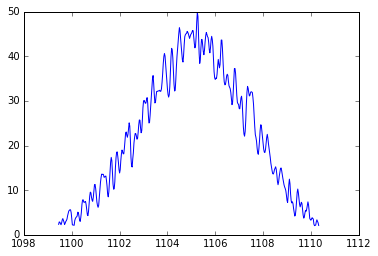

hit return
S12 number = 9, samples = 528 sum in pes =19521.5927367


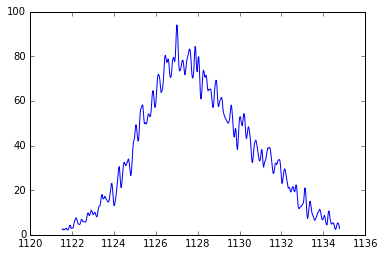

hit return
S12 number = 10, samples = 15 sum in pes =62.2009334395


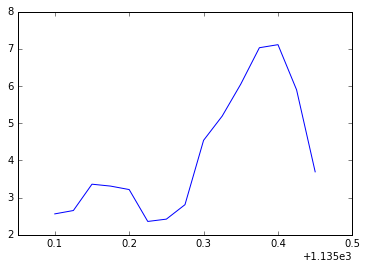

hit return
S12 number = 11, samples = 253 sum in pes =2097.65066927


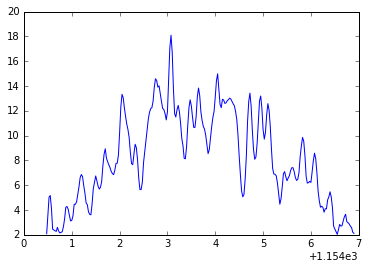

hit return


In [138]:
scan_S12(S12)

### Event 5

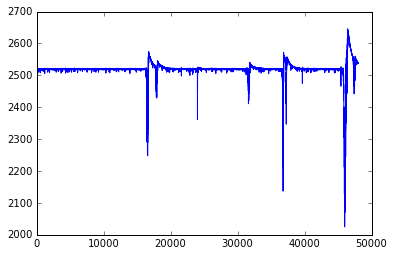

In [139]:
plt.plot(pmtrwf[4,0])

In [140]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=4, threshold=2, stride=4, lmin=8)

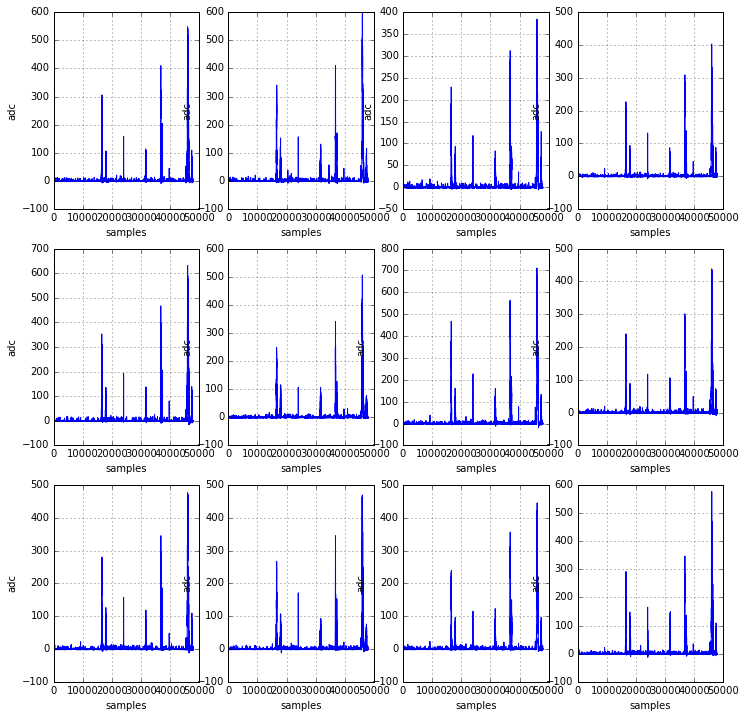

In [141]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=False, window_size=3000)

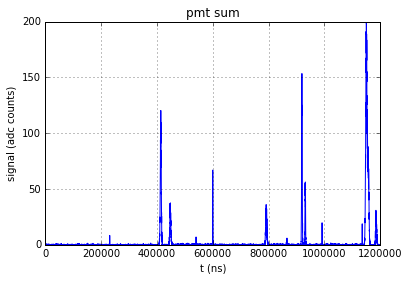

In [142]:
plot_signal(signal_t, pmtsum , title="pmt sum",
                signal_start=0, signal_end=1200e+3, ymax = 200, units="adc counts")

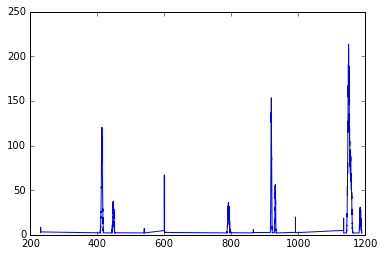

In [143]:
plt.plot(wfzs.time_mus.values,wfzs.ene_pes)

In [144]:
def plot_wf(pmtsum,wfzs):
    plot_signal(signal_t, pmtsum , title="pmt sum",
                signal_start=0, signal_end=1200e+3, ymax = 200, units="adc counts")
    plt.show()
    raw_input('hit return')
    plt.plot(wfzs.time_mus.values,wfzs.ene_pes)
    plt.show()
    
    

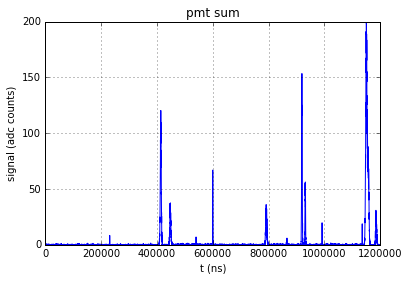

hit return


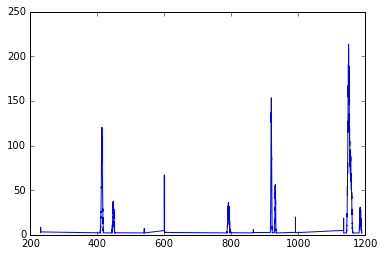

In [145]:
plot_wf(pmtsum,wfzs)

S12 number = 0, samples = 390 sum in pes =17777.9875657


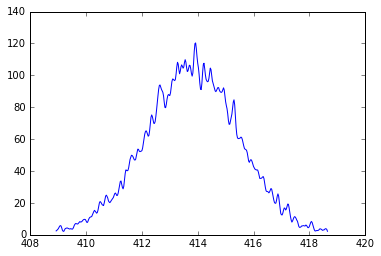

hit return
S12 number = 1, samples = 339 sum in pes =5618.40912433


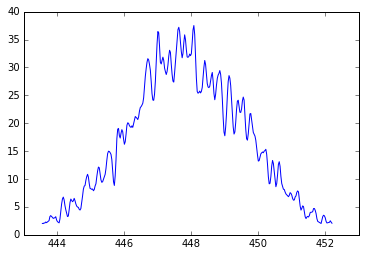

hit return
S12 number = 2, samples = 30 sum in pes =915.747991922


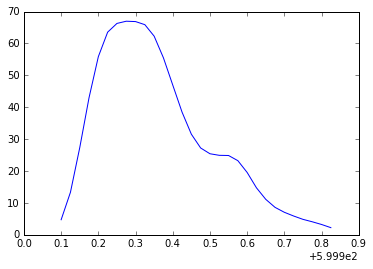

hit return
S12 number = 3, samples = 388 sum in pes =6285.12709901


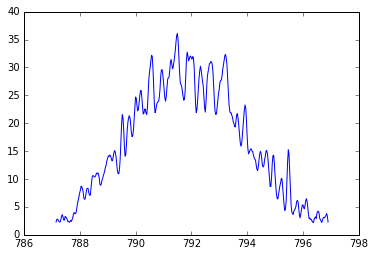

hit return
S12 number = 4, samples = 235 sum in pes =14840.2592099


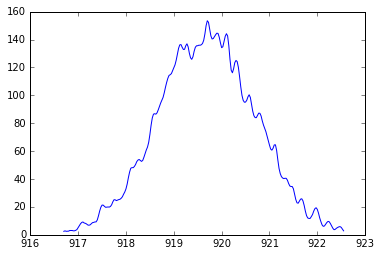

hit return
S12 number = 5, samples = 206 sum in pes =5071.4744554


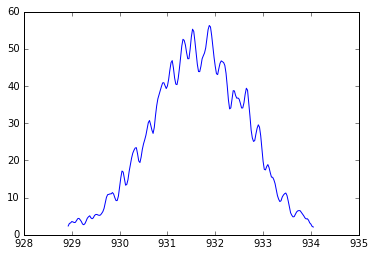

hit return
S12 number = 6, samples = 10 sum in pes =108.595955331


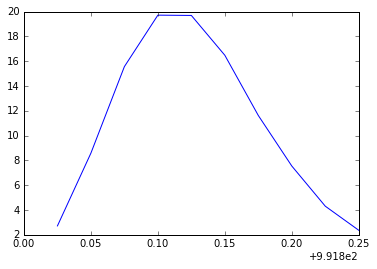

hit return
S12 number = 7, samples = 738 sum in pes =60417.1687738


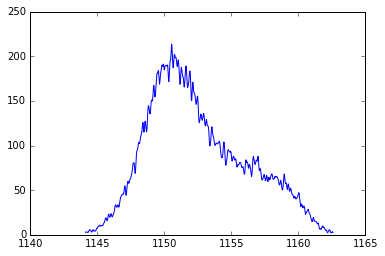

hit return
S12 number = 8, samples = 288 sum in pes =4357.31078399


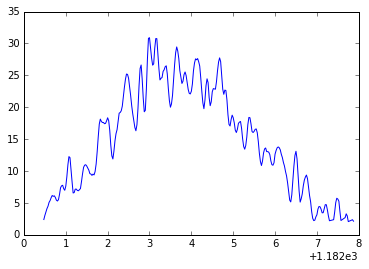

hit return


In [146]:
scan_S12(S12)

### Event 6

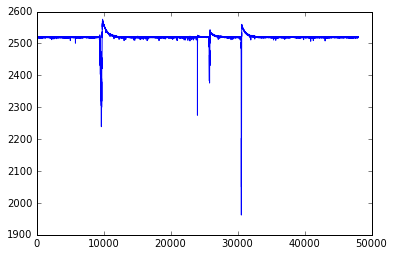

In [147]:
plt.plot(pmtrwf[5,0])

In [150]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=5, threshold=2, stride=4, lmin=8)

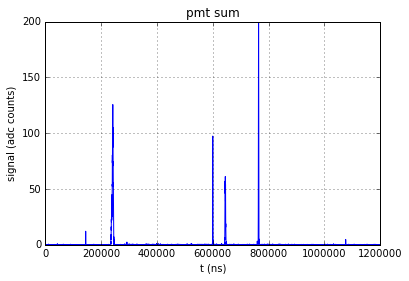

hit return


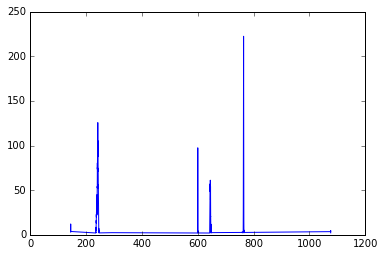

In [151]:
plot_wf(pmtsum,wfzs)

S12 number = 0, samples = 453 sum in pes =19609.3662855


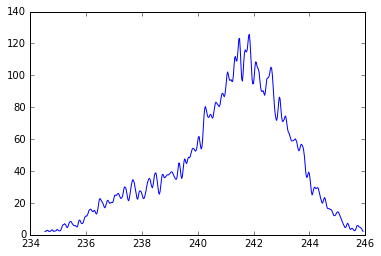

hit return
S12 number = 1, samples = 24 sum in pes =973.617740687


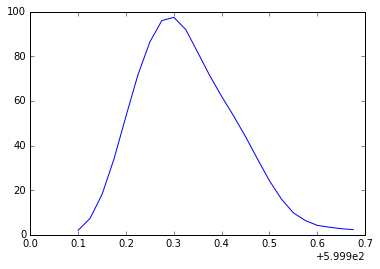

hit return
S12 number = 2, samples = 197 sum in pes =5632.34782401


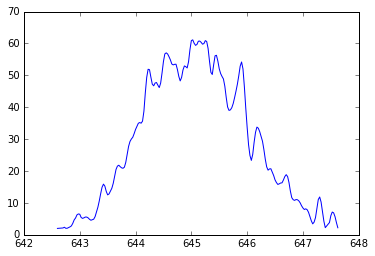

hit return
S12 number = 3, samples = 108 sum in pes =11109.597191


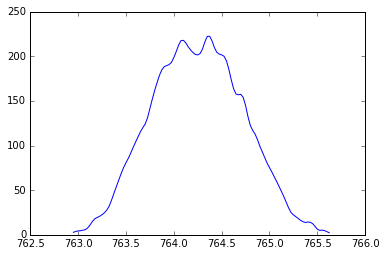

hit return


In [152]:
scan_S12(S12)

### Event 7

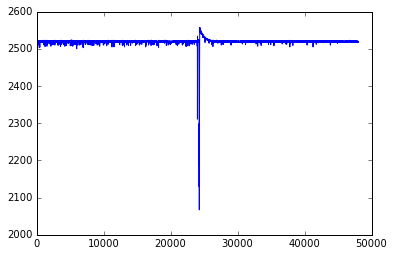

In [153]:
plt.plot(pmtrwf[6,0])

In [156]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=6, threshold=2, stride=4, lmin=8)

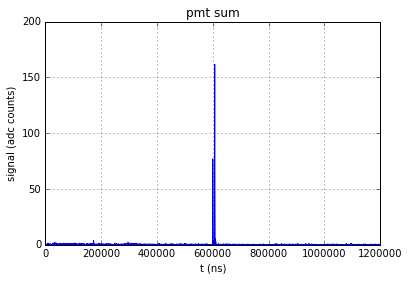

hit return


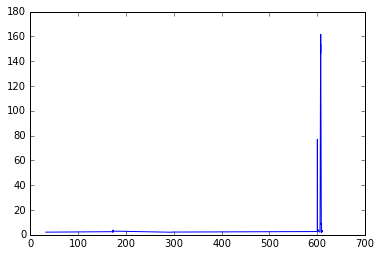

In [157]:
plot_wf(pmtsum,wfzs)

S12 number = 0, samples = 19 sum in pes =845.775460038


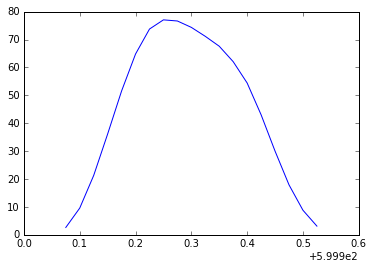

hit return
S12 number = 1, samples = 138 sum in pes =9626.16028947


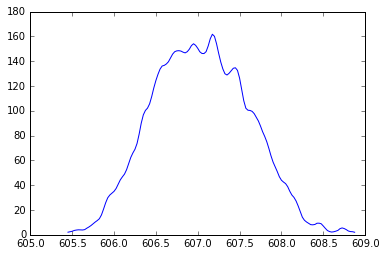

hit return


In [158]:
scan_S12(S12)

### Event 8

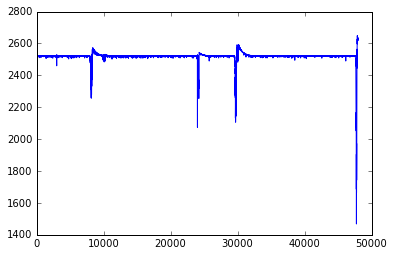

In [159]:
plt.plot(pmtrwf[7,0])

In [160]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=7, threshold=2, stride=4, lmin=8)

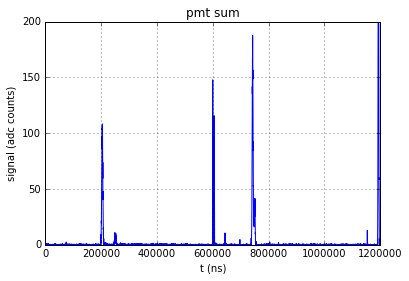

hit return


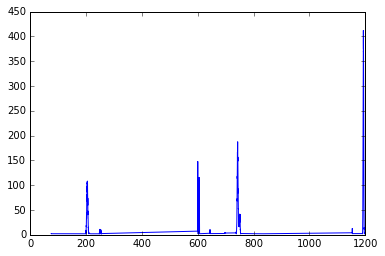

In [161]:
plot_wf(pmtsum,wfzs)

### Event 9

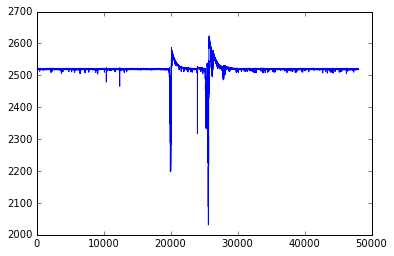

In [162]:
plt.plot(pmtrwf[8,0])

In [176]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=8, threshold=2, stride=40, lmin=8)

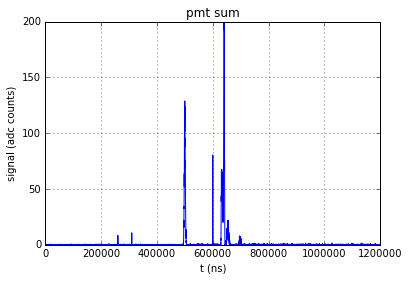

hit return


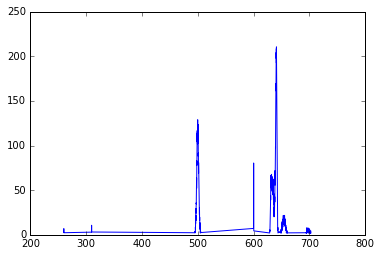

In [177]:
plot_wf(pmtsum,wfzs)

number of peaks = 5
S12 number = 0, samples = 410 sum in pes =20607.065705


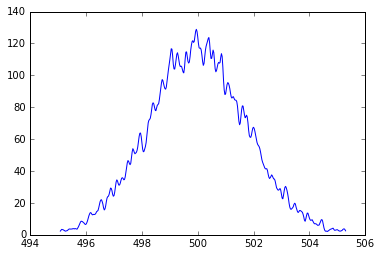

hit return
S12 number = 1, samples = 20 sum in pes =937.293382179


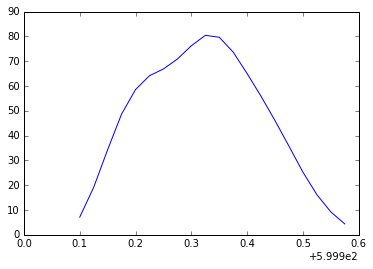

hit return
S12 number = 2, samples = 593 sum in pes =38902.5231911


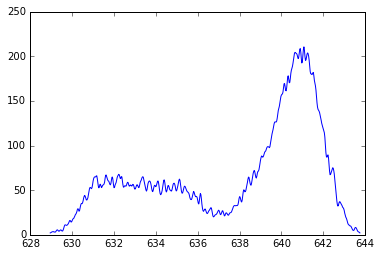

hit return
S12 number = 3, samples = 444 sum in pes =4679.61877257


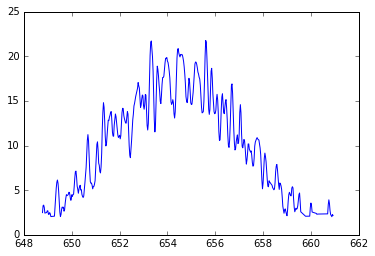

hit return
S12 number = 4, samples = 268 sum in pes =1092.80948688


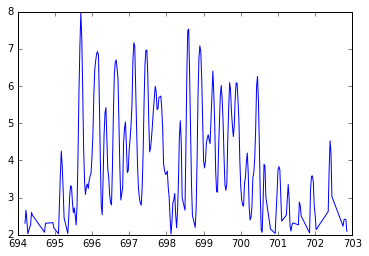

hit return


In [178]:
scan_S12(S12)

### Event 10

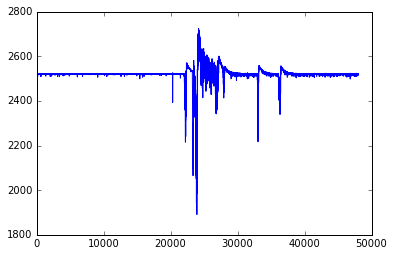

In [179]:
plt.plot(pmtrwf[9,0])

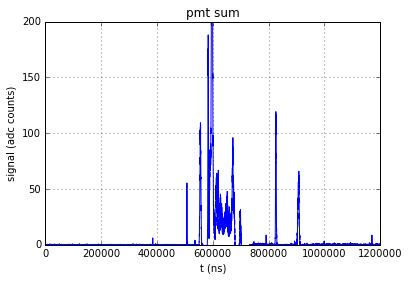

hit return


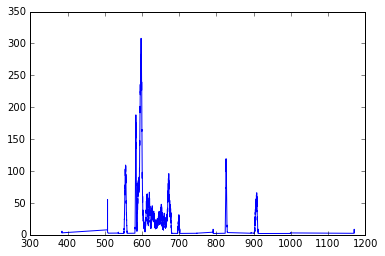

number of peaks = 7
S12 number = 0, samples = 10 sum in pes =294.624696091


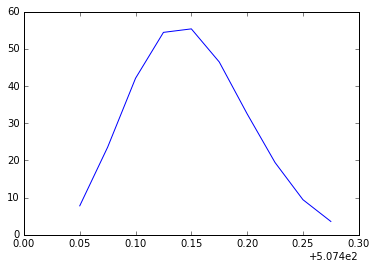

hit return
S12 number = 1, samples = 356 sum in pes =17298.1990967


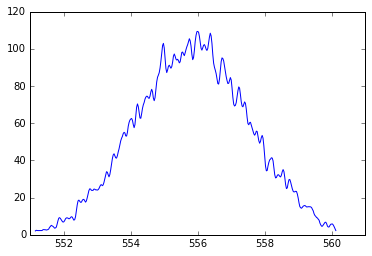

hit return
S12 number = 2, samples = 3954 sum in pes =187254.014095


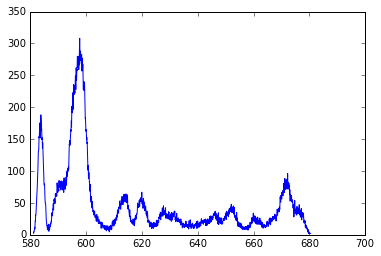

hit return
S12 number = 3, samples = 250 sum in pes =3628.60492804


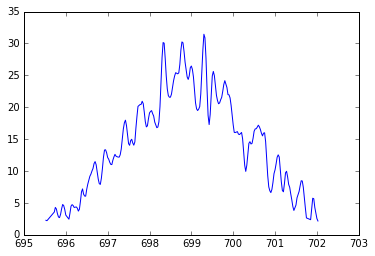

hit return
S12 number = 4, samples = 10 sum in pes =58.0670628407


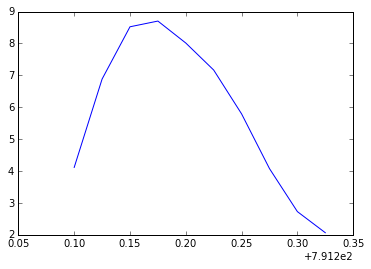

hit return
S12 number = 5, samples = 232 sum in pes =12215.1212678


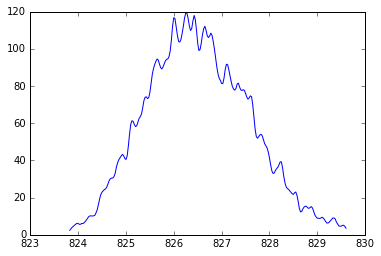

hit return
S12 number = 6, samples = 397 sum in pes =12148.509917


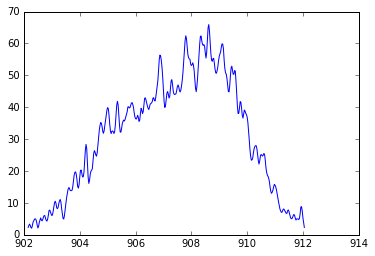

hit return


In [180]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=9, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)
scan_S12(S12)

### Event 11

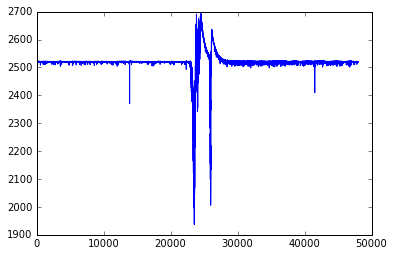

In [181]:
plt.plot(pmtrwf[10,0])

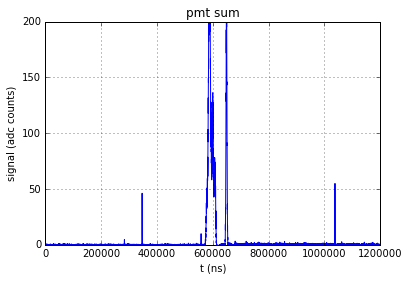

hit return


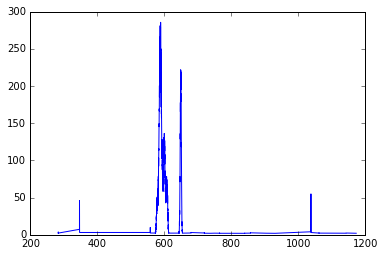

In [183]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=10, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)

number of peaks = 4
S12 number = 0, samples = 13 sum in pes =293.071194506


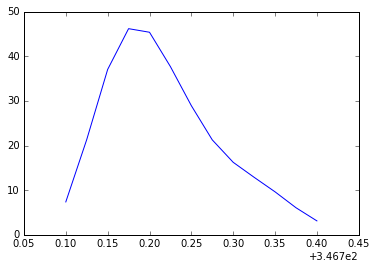

hit return
S12 number = 1, samples = 1586 sum in pes =147904.877557


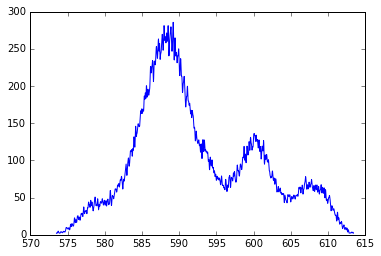

hit return
S12 number = 2, samples = 388 sum in pes =35403.4384511


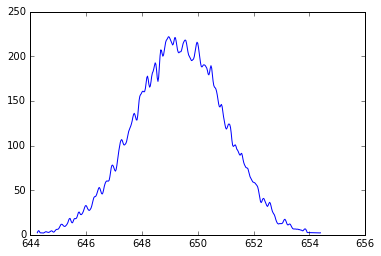

hit return
S12 number = 3, samples = 12 sum in pes =322.715371867


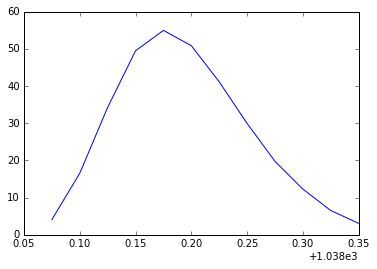

hit return


In [184]:
scan_S12(S12)

### Event 12

#### Event with S1 and S2

In this event one can see clearly a large S1 and a large S2, possibly with an additional interaction in it...

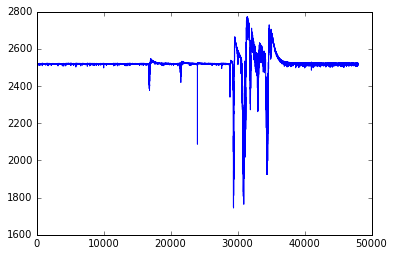

In [185]:
plt.plot(pmtrwf[11,0])

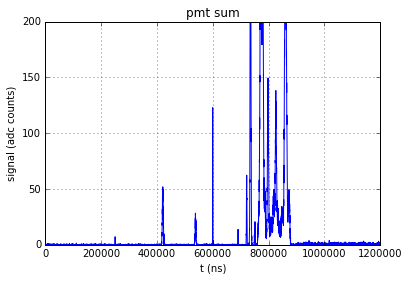

hit return


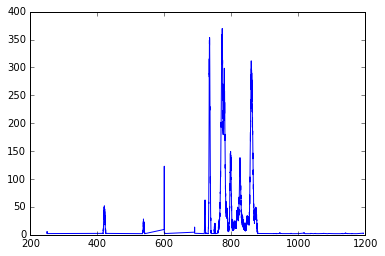

In [186]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=11, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)

number of peaks = 8
S12 number = 0, samples = 341 sum in pes =8153.98409048


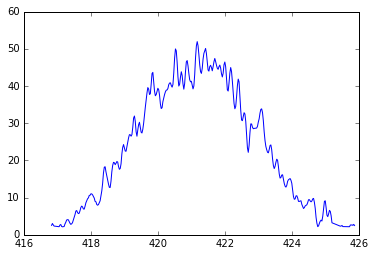

hit return
S12 number = 1, samples = 270 sum in pes =3292.36130329


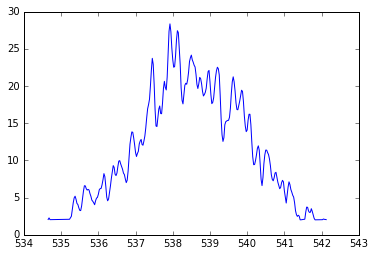

hit return
S12 number = 2, samples = 14 sum in pes =663.122255518


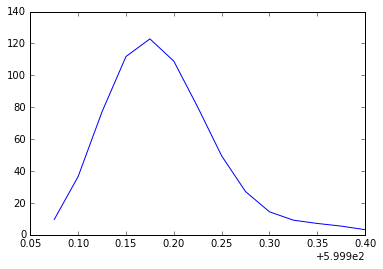

hit return
S12 number = 3, samples = 9 sum in pes =73.451085765


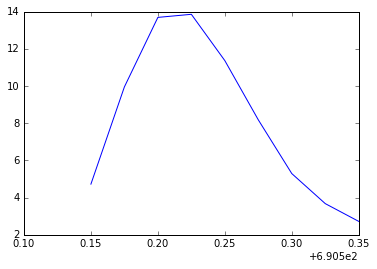

hit return
S12 number = 4, samples = 172 sum in pes =4657.1690444


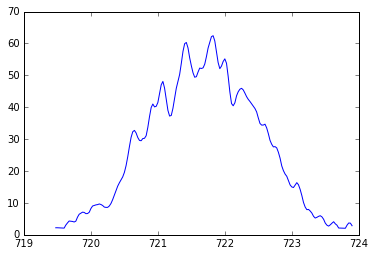

hit return
S12 number = 5, samples = 364 sum in pes =49497.3813132


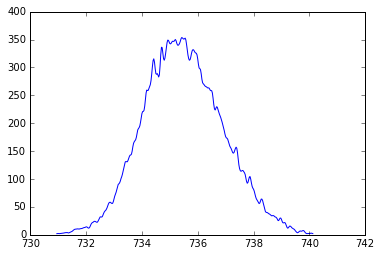

hit return
S12 number = 6, samples = 170 sum in pes =1658.16632885


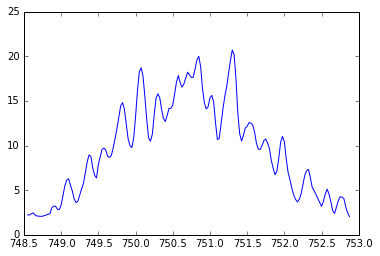

hit return
S12 number = 7, samples = 4741 sum in pes =357730.801843


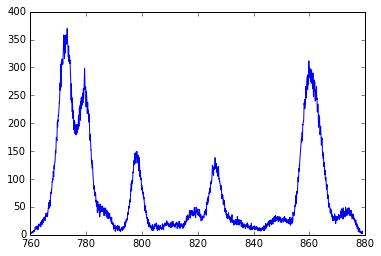

hit return


In [187]:
scan_S12(S12)

### Event 13

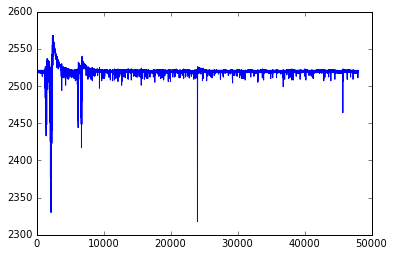

In [188]:
plt.plot(pmtrwf[12,0])

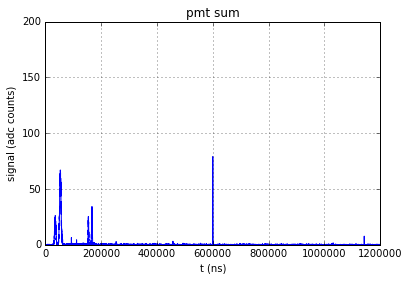

hit return


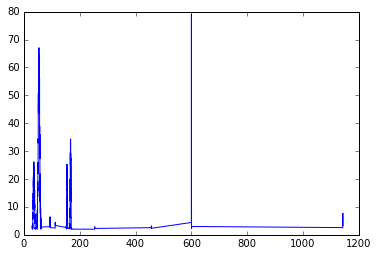

In [189]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=12, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)

number of peaks = 5
S12 number = 0, samples = 402 sum in pes =4622.62978908


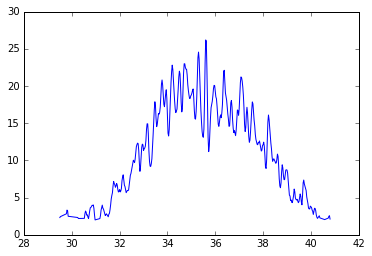

hit return
S12 number = 1, samples = 579 sum in pes =16430.6770841


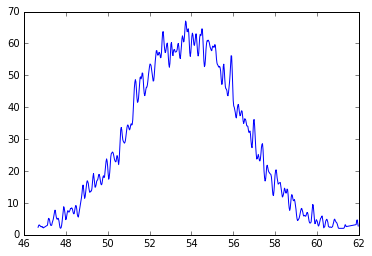

hit return
S12 number = 2, samples = 188 sum in pes =2280.78414206


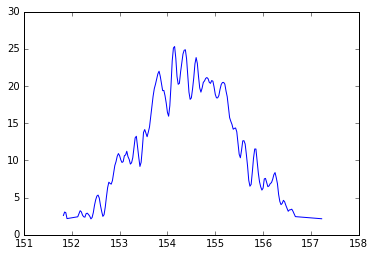

hit return
S12 number = 3, samples = 217 sum in pes =3545.2085378


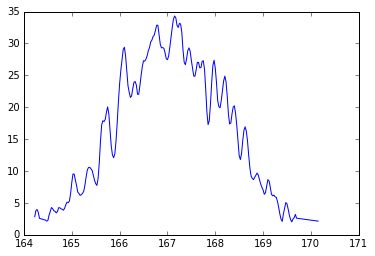

hit return
S12 number = 4, samples = 25 sum in pes =994.435242812


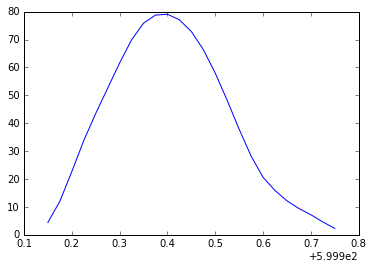

hit return


In [190]:
scan_S12(S12)

#### This is a fake S1, notice the rounded shape... it is also too long. 

### Event 14

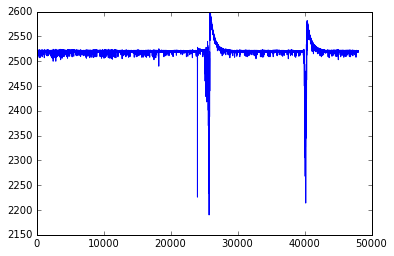

In [191]:
plt.plot(pmtrwf[13,0])

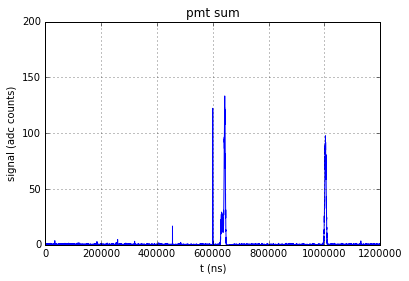

hit return


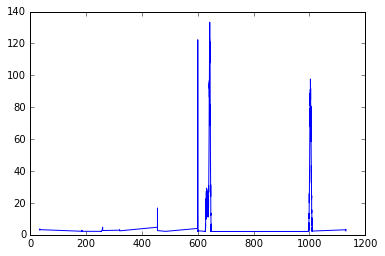

In [192]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=13, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)

number of peaks = 4
S12 number = 0, samples = 9 sum in pes =86.7803453151


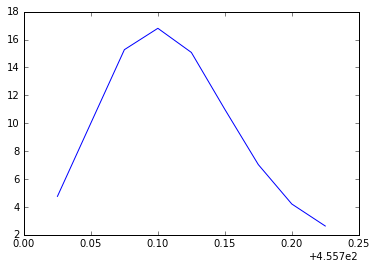

hit return
S12 number = 1, samples = 33 sum in pes =1279.09713869


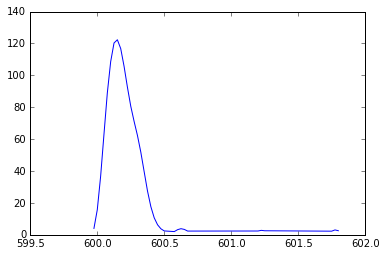

hit return
S12 number = 2, samples = 845 sum in pes =32043.4170454


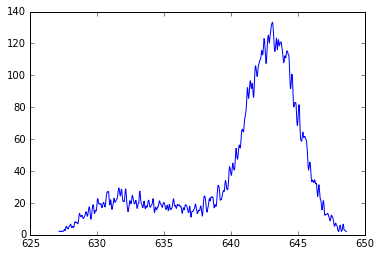

hit return
S12 number = 3, samples = 546 sum in pes =21907.8618768


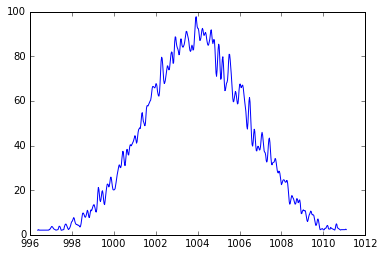

hit return


In [193]:
scan_S12(S12)

#### Fake S1

### Event 15

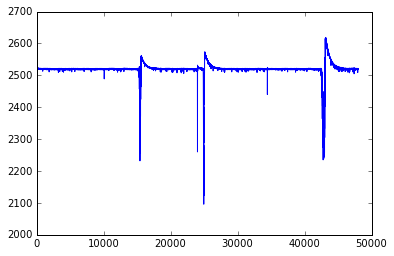

In [194]:
plt.plot(pmtrwf[14,0])

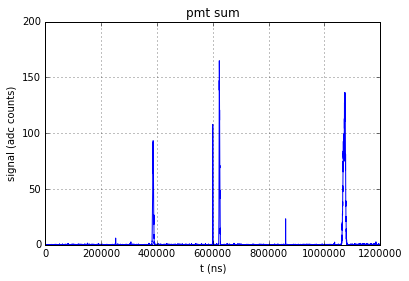

hit return


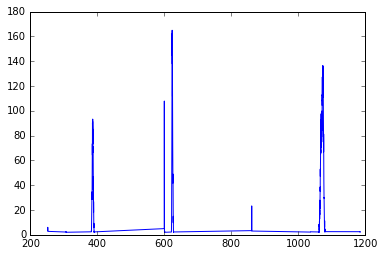

In [197]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=14, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)

number of peaks = 5
S12 number = 0, samples = 334 sum in pes =13210.1487119


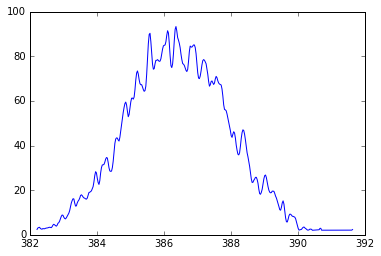

hit return
S12 number = 1, samples = 31 sum in pes =1447.67872936


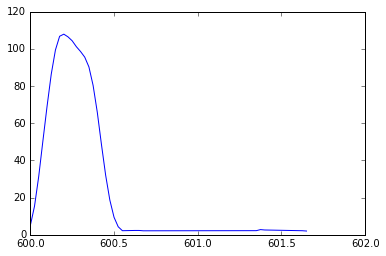

hit return
S12 number = 2, samples = 249 sum in pes =16672.9058707


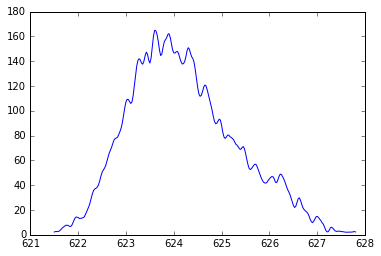

hit return
S12 number = 3, samples = 10 sum in pes =130.103097903


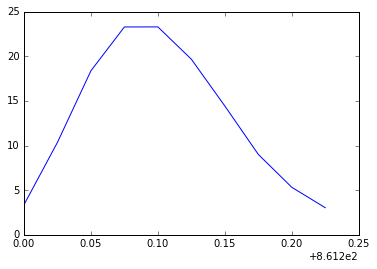

hit return
S12 number = 4, samples = 718 sum in pes =44182.6323663


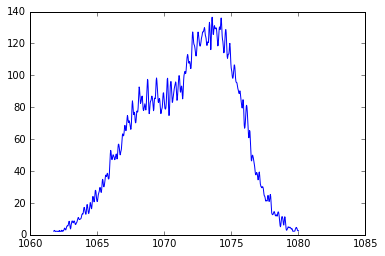

hit return


In [198]:
scan_S12(S12)

### Event 16

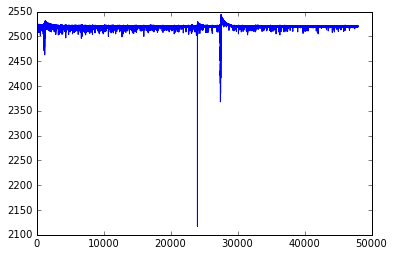

In [199]:
plt.plot(pmtrwf[15,0])

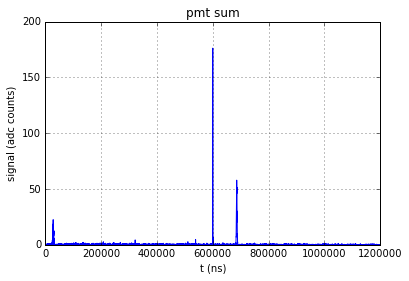

hit return


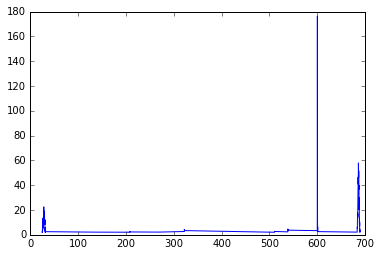

In [200]:
CWF, pmtsum, swf, wfzs, S12 = pmt_peaks(pmtrwf, DataPMT, event=15, threshold=2, stride=40, lmin=8)
plot_wf(pmtsum,wfzs)

number of peaks = 3
S12 number = 0, samples = 261 sum in pes =2612.16603267


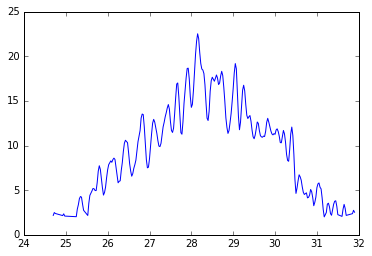

hit return
S12 number = 1, samples = 27 sum in pes =1525.07652261


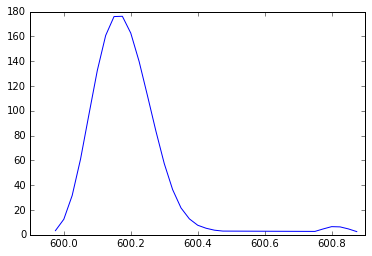

hit return
S12 number = 2, samples = 231 sum in pes =5958.6677954


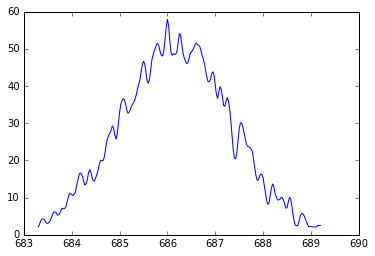

hit return


In [201]:
scan_S12(S12)

#### Fake S1

#### A fake S1

In [ ]:
def get_pmt_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    return pmtrwf,pmtdf,gdf

In [ ]:
def waveform_panel(pmtrwf,pmtdf,mau_len = 500, calib_constat =True, adc_to_pes=20, 
                   type = 'PMT', daq_ceiling=4096, event=0):
    """
    input: sensor (pmt or sipm) data vector, sensor data frame (position, calibration)
    returns: a panel holding waveforms for all sensors, and a series for the baselines
    """
    PMT = {}
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)
    pmt_len = pmtrwf.shape[2]
    NPMT = pmtrwf.shape[1]
    MAU = np.zeros(nm)
    BSL = {}
    
    time_ns = np.arange(pmt_len)*mus
    indx = np.arange(pmt_len)
    
    if type == 'PMT':
        time_ns = np.arange(pmt_len)*FP.time_DAQ
        
    ene_sum = 0
    for j in range(NPMT):
                     
        if calib_constat == True:
            adc_to_pes = abs(pmtdf['adc_to_pes'][j])
            
        signal_daq = pmtrwf[event,j]
        if type == 'PMT':
            signal_daq = daq_ceiling - pmtrwf[event,j]
            
        MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
        BASELINE = MAU[nm-1]
        
        ene_pes = (signal_daq - BASELINE)/adc_to_pes
        if type == 'PMT':
            ene_sum += ene_pes
            
        PMT[j] = wfdf(time_ns,ene_pes,indx)
        BSL[j] = BASELINE
    PMT[j+1] = wfdf(time_ns,ene_sum,indx)
    return pd.Panel(PMT),pd.Series(BSL)


In [ ]:
def plot_PPMT(pmt_panel, tmin=0, tmax=1200, emin = 0, emax = 10000, option='sum'):
    """
    Plots pmtwf
    """
    plt.figure(figsize=(10,10))
    
    if option == 'sum':
        ax1 = plt.subplot(1,1,1)
        ax1.set_xlim([tmin, tmax])
        ax1.set_ylim([emin, emax])
        indx = pmt_panel.items[-1]
        pmtwf = pmt_panel[indx]
        plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    else:
        
        for i in pmt_panel.items[0:-1]:
            ax1 = plt.subplot(3,4,int(i)+1)
            ax1.set_xlim([tmin, tmax])
            ax1.set_ylim([emin, emax])
        
            pmtwf = pmt_panel[i]
            plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    
    plt.show()

In [ ]:
def find_S12(swf, stride=40):
    """
    Find S1 or S2 signals. The input is a zero-supressed WF. The stride defines the contiguity criterium.
    The stride is applied to the indexes which keep the ordering of the original (non-zs) WF. 
    For example, with a stride of 40 (corresponding to steps of 1 mus for a DAQ timing of 25 ns) index 1
    and index 39 are in the same S12. 
    """
    T = swf['time_mus'].values
    P = swf['ene_pes'].values
    I = swf['indx'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(swf)) :
        if swf.index[i]-stride > swf.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i], columns=['time_mus','ene_pes','indx']))
    return S12L

In [ ]:
def energy_sum(sensor_panel, thr=0):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    EPES = []

    for i in sensor_panel.items[0:-1]:
        pmtwf = sensor_panel[i]
        EPES.append(np.sum(pmtwf.ene_pes.values[np.where(pmtwf.ene_pes.values>thr)]))
    return pd.Series(EPES) 

In [ ]:
def plot_sensors(geom_df,sensor_df, energy, radius=10):
    """
    plots the energy of the sensors 
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    mpl.circles(x, y, r, c=energy, alpha=0.5, ec='none')
    plt.colorbar()
    
    plt.xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    plt.ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    

In [ ]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    t = swf['time_mus'].values
    e = swf['ene_pes'].values
    I = swf['indx'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb)
    E = np.zeros(lenb)
    II = np.zeros(lenb, dtype=int)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        II[i] = I[(j+stride)/2]
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
        II[n] = I[(len(swf) - j/2)]
    
   
    rbw={}
    rbw['ene_pes'] = E
    rbw['time_mus'] = T
    rbw['indx'] = II
    return pd.DataFrame(rbw)

In [ ]:
def find_t0(s1):
    """
    returns t0
    """
    emax = np.amax(s1.ene_pes.values)
    return s1.loc[lambda df: df.ene_pes.values ==emax, :]

In [ ]:
def s12_energy(s12):
    """
    total energy in pes
    """
    return np.sum(s12.ene_pes.values)

In [ ]:
def s12_length(s12):
    """
    s2 length in mus
    """
    
    return s12.describe().time_mus['max'] - s12.describe().time_mus['min']

In [ ]:
def s12_peak(s2):
    """
    s2 peak in mus
    """
        
    return s12.describe().time_mus['max'], s2.describe().ene_pes['max']

In [ ]:
def find_t(s1,s2):
    """
    returns the time of the interaction
    """
    t0 = find_t0(s1).time_mus.values[0]
    ts2,es2 = s12_peak(s2)
    return ts2 - t0
        

In [ ]:
def sipm_s2(sipmdf, s2df):
    """
    Takes a sipm DF and an s2df
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipmdf.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu

In [ ]:
def sipm_s2_panel(sipmp, s2, thr_min=0.5, thr_s2 =1, event_number=0):
    """
    Takes a sipmp
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    
    j=0
    SIPM={}
    ESIPM=[]
    for i in (sipmp.items):
        sipm = sipmp[i]
        ESIPM.append(np.sum(sipm.ene_pes))
        
        if np.sum(sipm.ene_pes) < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        sipms2 = sipm_s2(sipm, s2)
        if np.sum(sipms2).ene_pes > thr_s2:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM), np.array(ESIPM)
 

In [ ]:
def sipm_s2_energy(sipmp, s2, thr_min=0.5, thr_s2 =0.5):
    """
    Takes a sipmp
    Returns a sipm panel where every member is a SiPM which has energy above trheshold:
    The energy of the SiPM corresponds to the S2 width

    """
    
    j=0
    SIPM={}
    for i in (sipmp.items):
        sipm = sipmp[i]
        etot = np.sum(sipm.ene_pes)
        if etot < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        sipms2 = sipm_s2(sipm, s2)
        es2 = np.sum(sipms2).ene_pes
        if es2 > thr_s2:
            DATA = []
            DATA.append(i)
            DATA.append(etot)
            DATA.append(es2)
            SIPM[j] = DATA
            j+=1
    return pd.DataFrame(data=SIPM.values(), index=SIPM.keys(), columns=['sipm_indx','etot_pes','es2_pes'])

In [ ]:
def pmt_barycenter(geom_df,sensor_df, energy):
    """
    plots the energy of the sensors 
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    etot = np.sum(energy)
    xb = np.dot(x,energy)/etot
    yb = np.dot(y,energy)/etot
    
    return xb,yb

In [ ]:
def sPMT(pmt_panel):
    return pmt_panel[PMT.items[-1]]

### RUN 2297

In [ ]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

In [ ]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=0)

In [ ]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 50, option='all')

In [ ]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 200, option='sum')

In [ ]:
PMT.items

In [ ]:
wf_zs = wf_thr(sPMT(PMT),threshold=6)

In [ ]:
plt.plot(wf_zs.ene_pes)

In [ ]:
s12 = find_S12(wf_zs)

In [ ]:
len(s12)

In [ ]:
plt.plot(s12[0].ene_pes)

In [ ]:
plt.plot(s12[1].ene_pes)

In [ ]:
s1 = s12[0]

In [ ]:
s2 = s12[1]

In [ ]:
s2rb = rebin_waveform(s2, stride = 40)

In [ ]:
plt.plot(s2rb['time_mus'], s2rb['ene_pes'])

In [ ]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

In [ ]:
print("t0 = {} mus".format(find_t0(s1).time_mus.values[0]))

In [ ]:
s2rb.describe()

In [ ]:
s2rb.describe().ene_pes

In [ ]:
s2rb.describe().ene_pes['max']

In [ ]:
ts2, emaxs2 = s2_peak(s2)

In [ ]:
print("ts2 = {} mus, emax = {} pes".format(ts2,emaxs2))

In [ ]:
print('tint = {} mus '.format(find_t(s1,s2)))

### SiPMs

In [ ]:
SIPM, SIBSL  = waveform_panel(sipmrwf,sipmdf,mau_len = 100, calib_constat =False, adc_to_pes=20, type = 'SIPM', event=0)

In [ ]:
mpl.plts(SIBSL, signal_start=0, signal_end=250, offset=10)

In [ ]:
SIBSL.describe()

In [ ]:
SIPM

In [ ]:
esipmdf = sipm_s2_energy(SIPM, s2, thr_min=25, thr_s2 =2.0)

In [ ]:
plt.plot(esipmdf.sipm_indx,esipmdf.etot_pes)

In [ ]:
plt.plot(esipmdf.sipm_indx,esipmdf.es2_pes)

In [ ]:
esipmdf

In [ ]:
epmt = energy_sum(PMT, thr=0)

In [ ]:
plt.plot(epmt)

In [ ]:
esipm = energy_sum(SIPM, thr=0)

In [ ]:
plt.plot(esipm)

In [ ]:
plot_sensors(gdf,pmtdf, epmt, radius=10)

In [ ]:
plot_sensors(gdf,sipmdf, esipm, radius=2)

In [ ]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=1)

In [ ]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 60, option='all')

In [ ]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 250, option='sum')

In [ ]:
wf_zs = wf_thr(sPMT(PMT),threshold=6)

In [ ]:
plt.plot(wf_zs.ene_pes)

In [ ]:
s12 = find_S12(wf_zs)

In [ ]:
len(s12)

In [ ]:
s1 = s12[0]
s2 = s12[1]

In [ ]:
s2rb = rebin_waveform(s2, stride = 40)

In [ ]:
plt.plot(s2rb['time_mus'], s2rb['ene_pes'])

In [ ]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

In [ ]:
print("t0 = {} mus".format(find_t0(s1).time_mus.values[0]))

In [ ]:
ts2, emaxs2 = s2_peak(s2)

In [ ]:
print("ts2 = {} mus, emax = {} pes".format(ts2,emaxs2))

In [ ]:
print('tint = {} mus '.format(find_t(s1,s2)))

In [ ]:
SIPM, SIBSL  = waveform_panel(sipmrwf,sipmdf,mau_len = 100, calib_constat =False, adc_to_pes=20, type = 'SIPM', event=1)

In [ ]:
mpl.plts(SIBSL, signal_start=0, signal_end=250, offset=10)

In [ ]:
esipmdf = sipm_s2_energy(SIPM, s2, thr_min=0, thr_s2 =0)

In [ ]:
plt.plot(esipmdf.sipm_indx,esipmdf.etot_pes)

### RUN 2366

In [ ]:
!ls -lh ../../../waveforms/hdf5/*2366*.h5

In [ ]:
h5f =tb.open_file('../../../waveforms/hdf5/run_2366.gdc1next.000.next1el_2366.root.h5')

In [ ]:
h5f

In [ ]:
pmtrwf,pmtdf,gdf =get_pmt_vectors(h5f)

In [ ]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=0)

In [ ]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 20, option='all')

In [ ]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 150, option='sum')

In [ ]:
plot_PPMT(PMT, tmin=250, tmax=450, emin = -10, emax = 250, option='sum')

In [ ]:
plot_PPMT(PMT, tmin=550, tmax=750, emin = -10, emax = 50, option='sum')

In [ ]:
s12 = find_S12(wf_thr(sPMT(PMT),threshold=6))

In [ ]:
len(s12)

In [ ]:
len(s12[0])

In [ ]:
len(s12[1])

In [ ]:
len(s12[2])

In [ ]:
s1 = s12[0]

In [ ]:
s2 = s12[2]

In [ ]:
np.sum(s2.ene_pes.values)

In [ ]:
find_t0(s1)

In [ ]:
ts2, emaxs2 = s2_peak(s2)

In [ ]:
ts2

In [ ]:
emaxs2

In [ ]:
find_t(s1,s2)

In [ ]:
epmt = energy_sum(PMT, thr=0)

In [ ]:
plt.plot(epmt)

In [ ]:
plot_sensors(gdf,pmtdf, epmt, radius=10)

In [ ]:
x = pmtdf['x'].values

In [ ]:
x

In [ ]:
np.dot(x,epmt)/np.sum(epmt)

In [ ]:
y = pmtdf['y'].values

In [ ]:
np.dot(y,epmt)/np.sum(epmt)

In [ ]:
epmt

In [ ]:
s2.describe()

In [ ]:
s1.describe()

In [ ]:
s1.describe().time_mus.max()

In [ ]:
def pmt_alpha(pmtrwf,pmtdf, geomdf, thr=7*pes, t_trigger = 600, log='INFO', plot=False, event_list=[0]):
    """
    alpha analysis based on PMTs
    """
    lg = 'logging.'+DEBUG
    logger.setLevel(eval(lg))

    evl = len(event_list)
    t0 = np.zeros(evl, dtype=np.float32)
    t = np.zeros(evl, dtype=np.float32)
    xb = np.zeros(evl, dtype=np.float32)
    yb = np.zeros(evl, dtype=np.float32)
    s2e = np.zeros(evl, dtype=np.float32)
    s2l = np.zeros(evl, dtype=np.float32)
    ns1 = np.zeros(evl, dtype=np.int32)
    ns2 = np.zeros(evl, dtype=np.int32)

    for event in event_list:
        logger.info('event = {}'.format(event))

        PMT, BSL  = waveform_panel(pmtrwf,pmtdf,event=event)
        if plot:
            plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 20, option='all')
            plt.show()
            wait()
            plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 150, option='sum')
            plt.show()
            wait()

        s12 = find_S12(wf_thr(sPMT(PMT),threshold=thr))

        logger.debug('length of s12 = {}'.format(len(s12)))
        S1 = []
        S2 = []
        for s in s12:
            logger.debug('evaluating s in s12: s ={}'.format(s.describe()))
            logger.debug('tmax ={}'.format(s.describe().time_mus.max()))
            if s.describe().time_mus.max() < t_trigger: #s1
                S1.append(s)
            else:
                S2.append(s)

        logger.debug('length of S1 list = {}'.format(len(S1)))
        logger.debug('length of S2 list = {}'.format(len(S2)))

        if (len(S1) == 0):
            logger.warning("S1 not found, ignore event")
            t0[event] = -999
            t[event] = -999
            xb[event] = -999
            yb[event] = -999
            s2e[event] = -999
            s2l[event] = -999
            ns1[event] = 0
            ns2[event] = len(S2)
            continue
        if (len(S2) == 0):
            logger.warning("S2 not found, ignore event")
            t0[event] = -999
            t[event] = -999
            xb[event] = -999
            yb[event] = -999
            s2e[event] = -999
            s2l[event] = -999
            ns1[event] = len(S1)
            ns2[event] = 0
            continue

        ns1[event] = len(S1)
        ns2[event] = len(S2)

        s1 = S1[0]

        if len(S1) > 1:
            cmax = 0
            i=0
            imax = 0
            for s in S1:
                if s.describe().time_mus.count() > cmax:
                    cmax = s.describe().time_mus.count()
                    imax = i
            i+=1
            s1 = S1[imax]

        logger.debug('found s1 = {}'.format(s1.describe()))



        s2 = S2[0]
        es2 = s12_energy(s2)

        if len(S2) > 1:
            emax = 0
            i=0
            imax = 0
            for s in S2:
                es2 = s12_energy(s)
                if es2 > emax:
                    emax =  es2
                    imax = i
            i+=1
            s2 = S2[imax]

        epmt = energy_sum(PMT, thr=0)

        logger.debug('found s2 = {}'.format(s2.describe()))

        t0[event] = find_t0(s1)
        t[event] = find_t(s1,s2)
        xb[event], yb[event] = pmt_barycenter(pmtdf, epmt)
        s2l[event] = s12_length(s2)



In [ ]:
pmt_alpha(pmtrwf,pmtdf,thr=7, t_trigger = 600, event_list=[0,1,2])

In [ ]:
xb,yb = pmt_barycenter(gdf,pmtdf, epmt)

In [ ]:
print(xb,yb)

In [ ]:
s2_length(s2)

In [ ]:
s2_energy(s2)

In [ ]:
6./5.